# Model Attention LSTM

# Data collection

In [3]:
pip install yfinance

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 15.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 6.6 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-cp310-cp310-linux_x86_64.whl size=300752 sha256=e73f0abdde19433c83c7bf4d865a8ac75d339a0e3a8bd6ad966cea517c62c254
  Stored in directory: /root/.cache/pip/wheels/75/79/e5/8838db0594cc6c587142fd2563356392ade6255c5930411069
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


In [147]:
# Function to add financial indicators to the dataset

def add_financial_indicators(df):

    # Reformate the date as YYYY-MM-DD
    df.reset_index(inplace=True)
    df['Date'] = df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
    df.rename(columns={'Date': 'date'}, inplace=True)

    # Replace the MultiIndex columns with the first level
    df.columns = [col[0] for col in df.columns]

    # Calculate EMA over 20 days
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

    # Calculate RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Calculate MACD (Moving Average Convergence Divergence)
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Calculate Bollinger Bands
    rolling_mean = df['Close'].rolling(window=20).mean()
    rolling_std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = rolling_mean + 2 * rolling_std
    df['Bollinger_Lower'] = rolling_mean - 2 * rolling_std

    # Calculate Stochastic Oscillator
    lowest_low = df['Low'].rolling(window=14).min()
    highest_high = df['High'].rolling(window=14).max()
    df['Stochastic_K'] = ((df['Close'] - lowest_low) / (highest_high - lowest_low)) * 100
    df['Stochastic_D'] = df['Stochastic_K'].rolling(window=3).mean()

    # Calculate CCI (Commodity Channel Index)
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    tp_sma = typical_price.rolling(window=20).mean()
    tp_std = typical_price.rolling(window=20).std()
    df['CCI'] = (typical_price - tp_sma) / (0.015 * tp_std)

    # Calculate Momentum
    df['Momentum'] = df['Close'].diff(periods=10)

    return df

In [148]:
def prep_nan_data(df):
    # Delete any row with NaN values and create a new copy to avoid SettingWithCopyWarning
    no_nan_data = df.dropna().copy()

    # Add 'output' column with the next row's 'Adj Close' value
    no_nan_data['output'] = no_nan_data['Adj Close'].shift(-1)

    # Drop the final row as it lacks an 'output' value
    no_nan_data = no_nan_data.iloc[:-1]

    # Drop the 'date' column
    no_nan_data = no_nan_data.drop(columns=['date'])

    # Reset the index and return the processed DataFrame
    data = no_nan_data.reset_index(drop=True)
    return data


In [149]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def split_data(df):

    # Split into train and test sets (90% train, 10% test)
    train, test = train_test_split(df, test_size=0.2, shuffle=False)

    # Split the train set into train and validation sets (90% train, 10% validation)
    train, val = train_test_split(train, test_size=0.2, shuffle=False)

    # Apply MinMaxScaler
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    val = scaler.transform(val)
    test = scaler.transform(test)

    print(f"Training shape: {train.shape}")
    print(f"Validation shape: {val.shape}")
    print(f"Test shape: {test.shape}")

    return train, val, test

In [150]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Function to reshape the data for LSTM
def df_to_X_y(df, look_back_days=20):
    # df_to_np = df.to_numpy()
    # print(df_to_np.shape)

    X, y = [], []

    temp_X = df[:, :-1]
    print(temp_X.shape)

    temp_y = df[:, -1:]
    print(temp_y.shape)

    for i in range(len(temp_X)-look_back_days):
        row = [a for a in temp_X[i:i+look_back_days]]
        X.append(row)

    y = temp_y[look_back_days:]

        # label = temp_y[i+look_back_days]
        # y.append(label)

    return np.array(X), np.array(y)

In [154]:
def prepare_and_split_data(stock_list: list):

    all_X_training = []
    all_y_training = []
    all_X_val = []
    all_y_val = []
    all_X_test = []
    all_y_test = []
    
    for stock in stock_list:
    
        # Add financial indicators
        financial_data = add_financial_indicators(stock)

        # Remove the first 30 rows as they have been used to calculate indicators and contain NaN values
        no_nan_financial_data = financial_data[30:]
    
        # Add 'output' column with the next row's 'Adj Close' value
        financial_data_with_output = no_nan_financial_data.copy()
        financial_data_with_output['output'] = financial_data_with_output['Adj Close'].shift(-1)

        # Drop the final row as it lacks an 'output' value
        financial_data_with_output = financial_data_with_output.iloc[:-1]
    
        # Drop the 'date' column
        financial_data_with_output = financial_data_with_output.drop(columns=['date'])
    
        # Reset the index and return the processed DataFrame
        final_data = financial_data_with_output.reset_index(drop=True)

        # Split the dataset in train, val and test
        train_data, val_data, test_data = split_data(final_data)

        X_train, y_train = df_to_X_y(train_data)
        X_val, y_val = df_to_X_y(val_data)
        X_test, y_test = df_to_X_y(test_data)

        all_X_training.append(X_train)
        all_y_training.append(y_train)
        all_X_val.append(X_val)
        all_y_val.append(y_val)
        all_X_test.append(X_test)
        all_y_test.append(y_test)

    X_train = np.concatenate((all_X_training), axis=0)
    y_train = np.concatenate((all_y_training), axis=0)
    X_val = np.concatenate((all_X_val), axis=0)
    y_val = np.concatenate((all_y_val), axis=0)
    X_test = np.concatenate((all_X_test), axis=0)
    y_test = np.concatenate((all_y_test), axis=0)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [155]:
import yfinance as yf

# Load the financial data of AAPL, TSLA and BA
aapl_stock_price = yf.download('AAPL',
                               start='2018-01-01',
                               end='2023-12-31',
                               interval='1d')
tsla_stock_price = yf.download('TSLA',
                               start='2018-01-01',
                               end='2023-12-31',
                               interval='1d')
ba_stock_price = yf.download('BA',
                               start='2018-01-01',
                               end='2023-12-31',
                               interval='1d')
amzn_stock_price = yf.download('AMZN',
                               start='2018-01-01',
                               end='2023-12-31',
                               interval='1d')
goog_stock_price = yf.download('GOOG',
                               start='2018-01-01',
                               end='2023-12-31',
                               interval='1d')
nvda_stock_price = yf.download('NVDA',
                               start='2018-01-01',
                               end='2023-12-31',
                               interval='1d')

stocks = [
    aapl_stock_price,
    tsla_stock_price,
    ba_stock_price,
    amzn_stock_price,
    goog_stock_price,
    nvda_stock_price,
]

X_train, y_train, X_val, y_val, X_test, y_test = prepare_and_split_data(stock_list=stocks)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Training shape: (945, 17)
Validation shape: (237, 17)
Test shape: (296, 17)
(945, 16)
(945, 1)
(237, 16)
(237, 1)
(296, 16)
(296, 1)
Training shape: (945, 17)
Validation shape: (237, 17)
Test shape: (296, 17)
(945, 16)
(945, 1)
(237, 16)
(237, 1)
(296, 16)
(296, 1)
Training shape: (945, 17)
Validation shape: (237, 17)
Test shape: (296, 17)
(945, 16)
(945, 1)
(237, 16)
(237, 1)
(296, 16)
(296, 1)
Training shape: (945, 17)
Validation shape: (237, 17)
Test shape: (296, 17)
(945, 16)
(945, 1)
(237, 16)
(237, 1)
(296, 16)
(296, 1)
Training shape: (945, 17)
Validation shape: (237, 17)
Test shape: (296, 17)
(945, 16)
(945, 1)
(237, 16)
(237, 1)
(296, 16)
(296, 1)
Training shape: (945, 17)
Validation shape: (237, 17)
Test shape: (296, 17)
(945, 16)
(945, 1)
(237, 16)
(237, 1)
(296, 16)
(296, 1)


In [156]:
len(X_train)

5550

In [157]:
len(y_train)

5550

In [158]:
# Print new shapes
print("X_train_seq shape:", X_train.shape)  # (samples, timesteps, features)
print("y_train_seq shape:", y_train.shape)
print("X_val_seq shape:", X_val.shape)
print("y_val_seq shape:", y_val.shape)
print("X_test_seq shape:", X_test.shape)
print("y_test_seq shape:", y_test.shape)

X_train_seq shape: (5550, 20, 16)
y_train_seq shape: (5550, 1)
X_val_seq shape: (1302, 20, 16)
y_val_seq shape: (1302, 1)
X_test_seq shape: (1656, 20, 16)
y_test_seq shape: (1656, 1)


# Training the model

In [164]:
import tensorflow as tf
from keras.api.models import Model
from keras.api.layers import (
    Input,
    LSTM,
    Layer,
    Dense,
    Dropout,
    Activation,
    Attention,
    TimeDistributed,
    Concatenate,
    RepeatVector,
    Multiply,
    Lambda
)
from keras.api.saving import register_keras_serializable


@register_keras_serializable()
class SummedContextVector(Layer):
    def __init__(self, **kwargs):
        super(SummedContextVector, self).__init__(**kwargs)

    def call(self, inputs):
        # Sum over the time axis (axis=1)
        return tf.reduce_sum(inputs, axis=1)

# Define the LSTM model with Attention
def create_lstm_attention_model_V2(input_shape, num_lstm_units, dropout_rate):
    """
    Builds an LSTM model with an attention mechanism.

    Parameters:
    input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
    Model: A compiled Keras model with attention.
    """
    # Input layer
    inputs = Input(shape=input_shape)

    # LSTM Layer
    lstm_out, state_h, forward_c = LSTM(units=num_lstm_units,
                                          return_sequences=True,
                                          return_state=True)(inputs)


    # Attention Layer
    attention = Dense(1, activation="tanh")(lstm_out)
    attention_weights = Activation("sigmoid", name="Attention_Weights")(attention)
    context_vector = Multiply(name="Context_Vector")([attention_weights, lstm_out])

    # Sum over the time axis using the custom layer
    context_vector = SummedContextVector(name="Summed_Context_Vector")(context_vector)

    # Sum over the time axis using a Lambda layer
    # context_vector = Lambda(
    #     lambda x: tf.reduce_sum(x, axis=1), name="Summed_Context_Vector"
    # )(context_vector)
    # Combine Context and LSTM Final State
    combined_vector = Concatenate(name="Combined_Vector")(
        [context_vector, state_h]
    )

    # Combine Context and LSTM Final State
    combined_vector = Concatenate(name="Combined_Vector")(
        [context_vector, state_h]
    )

    # Fully Connected Layers
    dense1 = Dense(64, activation="sigmoid", name="Dense_1")(combined_vector)
    dropout = Dropout(dropout_rate, name="Dropout")(dense1)
    outputs = Dense(1, activation="sigmoid", name="Output_Layer")(dropout)

    # Define Model
    model = Model(inputs=inputs, outputs=outputs, name="Attention_LSTM_Model")

    return model


In [167]:
def train_loop(X_train, y_train,
               X_val, y_val,
               X_test, y_test,
               model_name,
               lstm_units,
               model_to_use=None):

    # Print new shapes
    print("X_train_seq shape:", X_train.shape)  # (samples, timesteps, features)
    print("y_train_seq shape:", y_train.shape)
    print("X_val_seq shape:", X_val.shape)
    print("y_val_seq shape:", y_val.shape)
    print("X_test_seq shape:", X_test.shape)
    print("y_test_seq shape:", y_test.shape)

    # Build the LSTM Model
    if model_to_use == None:
        print("Creating new model...")
        model_to_use = create_lstm_attention_model_V2(input_shape=(X_train.shape[1], X_train.shape[2]), num_lstm_units=lstm_units, dropout_rate=0.2)
        # print(model_to_use.summary())
    else:
        print("Using the loaded model")
        model_to_use = model_to_use

    # Compile the model
    model_to_use.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model
    start_time = time.time()
    history = model_to_use.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=30,
        verbose=1
    )
    end_time = time.time()

    # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the training and validation MAE
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the training time
    print(f"Training time: {(end_time - start_time)/60} minutes")

    # Evaluate on the test set
    test_loss, test_mae = model_to_use.evaluate(X_test, y_test, verbose=1)
    print("Test Loss:", test_loss)
    print("Test MAE:", test_mae)


    # Save the model
    model_to_use.save(f'{model_name}.keras')


## 128 

X_train_seq shape: (5550, 20, 16)
y_train_seq shape: (5550, 1)
X_val_seq shape: (1302, 20, 16)
y_val_seq shape: (1302, 1)
X_test_seq shape: (1656, 20, 16)
y_test_seq shape: (1656, 1)
Creating new model...
Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0160 - mae: 0.0875 - val_loss: 0.0082 - val_mae: 0.0697
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0029 - mae: 0.0391 - val_loss: 0.0064 - val_mae: 0.0595
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021 - mae: 0.0332 - val_loss: 0.0055 - val_mae: 0.0547
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - mae: 0.0294 - val_loss: 0.0076 - val_mae: 0.0688
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021 - mae: 0.0332 - val_loss: 0.0046 - val_mae: 0.0498
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013 - mae: 0.0265 - val_loss: 0.0046 - val_mae: 0.0505
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013 - mae: 0.0265 - val_

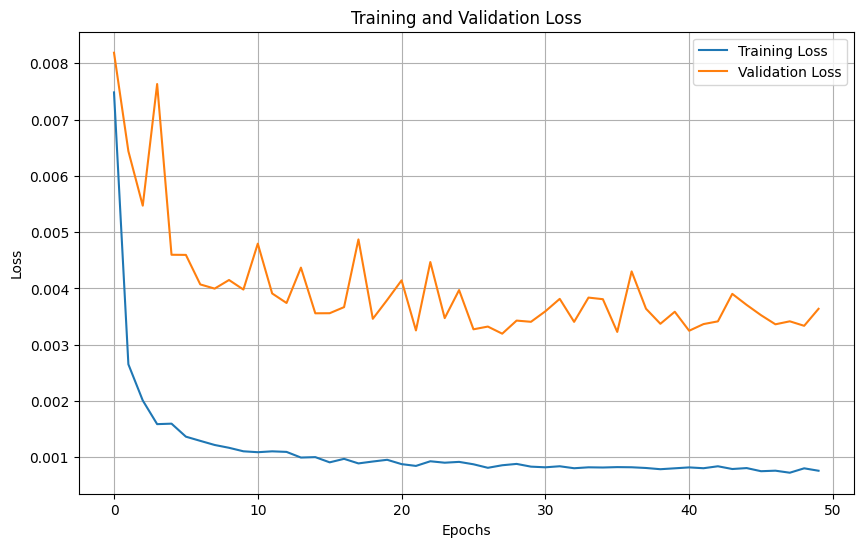

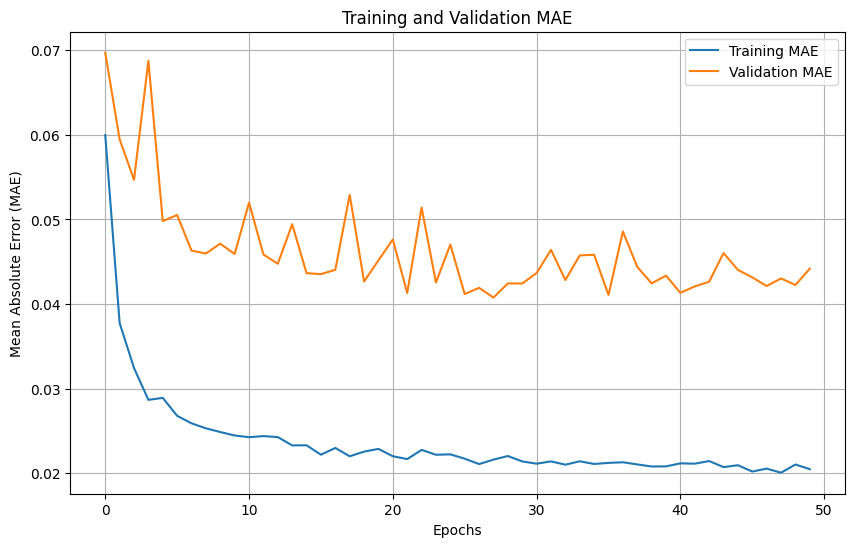

Training time: 0.8116242210070292 minutes
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - mae: 0.0779
Test Loss: 0.03295034542679787
Test MAE: 0.09234022349119186


In [168]:
train_loop(X_train, y_train, 
           X_val, y_val,
           X_test, y_test,
           "no_emotion_long_period_att_lstm",
            lstm_units=128)

## 256

X_train_seq shape: (5550, 20, 16)
y_train_seq shape: (5550, 1)
X_val_seq shape: (1302, 20, 16)
y_val_seq shape: (1302, 1)
X_test_seq shape: (1656, 20, 16)
y_test_seq shape: (1656, 1)
Creating new model...
Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0243 - mae: 0.1009 - val_loss: 0.0175 - val_mae: 0.1096
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0028 - mae: 0.0387 - val_loss: 0.0064 - val_mae: 0.0625
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020 - mae: 0.0325 - val_loss: 0.0053 - val_mae: 0.0546
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - mae: 0.0294 - val_loss: 0.0050 - val_mae: 0.0529
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - mae: 0.0295 - val_loss: 0.0042 - val_mae: 0.0485
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015 - mae: 0.0289 - val_loss: 0.0053 - val_mae: 0.0574
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013 - mae: 0.0259 - val_

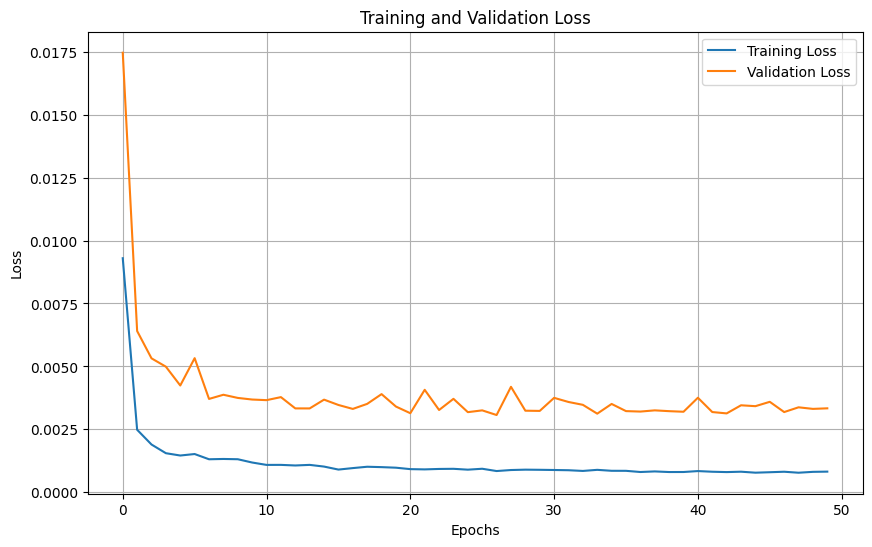

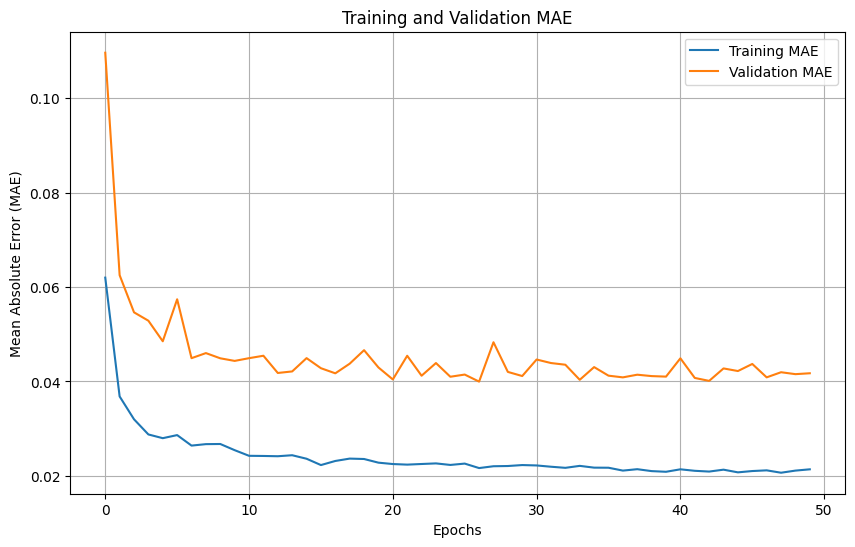

Training time: 0.7935033400853475 minutes
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - mae: 0.0771   
Test Loss: 0.03261737897992134
Test MAE: 0.09150192886590958


In [171]:
train_loop(X_train, y_train, 
           X_val, y_val,
           X_test, y_test,
           "no_emotion_att_lstm_256",
            lstm_units=256)

## 512

X_train_seq shape: (5550, 20, 16)
y_train_seq shape: (5550, 1)
X_val_seq shape: (1302, 20, 16)
y_val_seq shape: (1302, 1)
X_test_seq shape: (1656, 20, 16)
y_test_seq shape: (1656, 1)
Creating new model...
Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0140 - mae: 0.0797 - val_loss: 0.0095 - val_mae: 0.0794
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023 - mae: 0.0360 - val_loss: 0.0054 - val_mae: 0.0542
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - mae: 0.0292 - val_loss: 0.0061 - val_mae: 0.0601
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - mae: 0.0283 - val_loss: 0.0045 - val_mae: 0.0510
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - mae: 0.0298 - val_loss: 0.0040 - val_mae: 0.0472
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - mae: 0.0263 - val_loss: 0.0035 - val_mae: 0.0440
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - mae: 0.0261 - val_

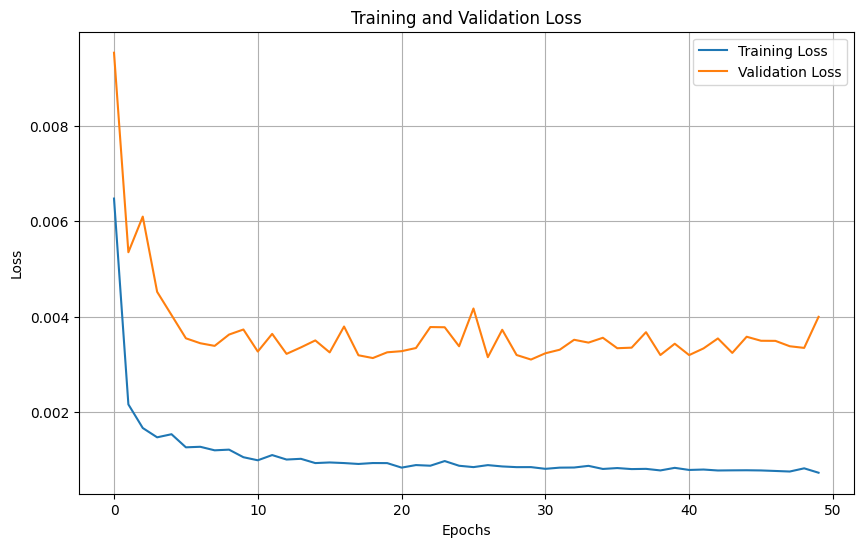

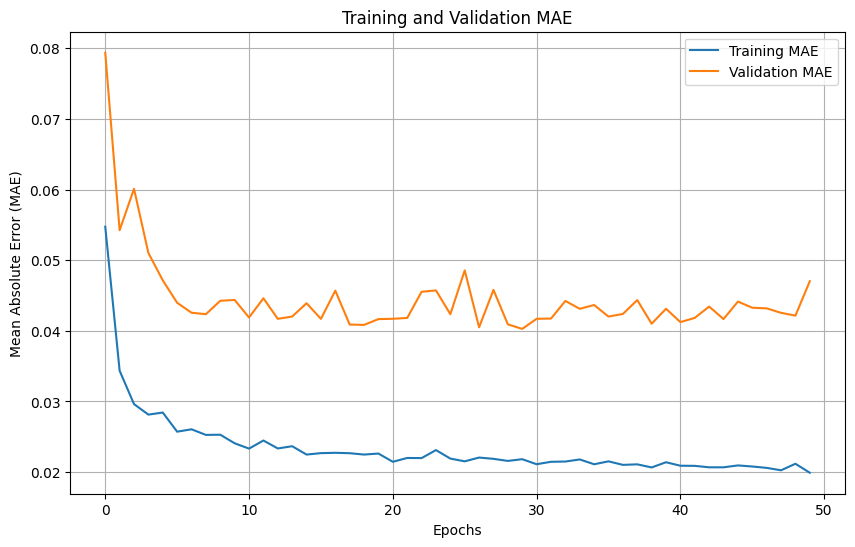

Training time: 0.9504998326301575 minutes
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - mae: 0.0786
Test Loss: 0.032824333757162094
Test MAE: 0.09281419217586517


In [172]:
train_loop(X_train, y_train, 
           X_val, y_val,
           X_test, y_test,
           "no_emotion_att_lstm_512",
            lstm_units=512)

# Evaluation

In [169]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def evaluate_model_V2(model, X_test, y_test):

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluation scores
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"R² - {model.name}: {r2}")
    print(f"MSE - {model.name}: {mse}")
    print(f"RMSE - {model.name}: {rmse}")
    print(f"MAE - {model.name}: {mae}")
    print(f"MAPE - {model.name}: {mape}")

    return r2, mse, rmse, mae, mape

In [173]:
# load models

model_128 = tf.keras.models.load_model('/kaggle/input/no_emotion_128/keras/default/1/no_emotion_long_period_att_lstm.keras')
model_256 = tf.keras.models.load_model('/kaggle/input/256-attention-lstm/keras/default/1/no_emotion_att_lstm_256.keras')
model_512 = tf.keras.models.load_model('/kaggle/input/512-attention-lstm/keras/default/1/no_emotion_att_lstm_512.keras')

# Evaluate them
print("Model 128")
evaluate_model_V2(model_128, X_test, y_test)
print("Model 256")
evaluate_model_V2(model_256, X_test, y_test)
print("Model 512")
evaluate_model_V2(model_512, X_test, y_test)


Model 128
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R² - Attention_LSTM_Model: 0.7790436640600709
MSE - Attention_LSTM_Model: 0.03295034280767221
RMSE - Attention_LSTM_Model: 0.18152229286694296
MAE - Attention_LSTM_Model: 0.09234021947947049
MAPE - Attention_LSTM_Model: 9.244309066248892
Model 256
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R² - Attention_LSTM_Model: 0.781276433109477
MSE - Attention_LSTM_Model: 0.03261737880700062
RMSE - Attention_LSTM_Model: 0.1806028205953623
MAE - Attention_LSTM_Model: 0.09150192549823796
MAPE - Attention_LSTM_Model: 9.023392516542888
Model 512
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R² - Attention_LSTM_Model: 0.779888638368299
MSE - Attention_LSTM_Model: 0.03282433513741756
RMSE - Attention_LSTM_Model: 0.18117487446502498
MAE - Attention_LSTM_Model: 0.0928141912888553
MAPE - Attention_LSTM_Model: 9.450367738193624


(0.779888638368299,
 0.03282433513741756,
 0.18117487446502498,
 0.0928141912888553,
 9.450367738193624)

# Stack LSTM with ATTENTION

In [177]:
import tensorflow as tf
from keras.api.models import Model
from keras.api.layers import (
    Input,
    LSTM,
    Layer,
    Dense,
    Dropout,
    Activation,
    Attention,
    TimeDistributed,
    Concatenate,
    RepeatVector,
    Multiply,
    Lambda
)
from keras.api.saving import register_keras_serializable


@register_keras_serializable()
class SummedContextVector(Layer):
    def __init__(self, **kwargs):
        super(SummedContextVector, self).__init__(**kwargs)

    def call(self, inputs):
        # Sum over the time axis (axis=1)
        return tf.reduce_sum(inputs, axis=1)


# Define the LSTM model with Attention
def create_stack_lstm_attention_model(input_shape, dropout_rate):
    """
    Builds an LSTM model with an attention mechanism and 3 LSTM layers.

    Parameters:
    input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
    Model: A compiled Keras model with attention.
    """
    # Input layer
    inputs = Input(shape=input_shape)

    # First LSTM Layer
    lstm_out_1, state_h_1, forward_c_1 = LSTM(units=256,
                                              return_sequences=True,
                                              return_state=True,)(inputs)

    # Second LSTM Layer
    lstm_out_2, state_h_2, forward_c_2 = LSTM(units=128,
                                              return_sequences=True,
                                              return_state=True)(lstm_out_1)

    # Third LSTM Layer
    lstm_out_3, state_h_3, forward_c_3 = LSTM(units=64,
                                              return_sequences=True,
                                              return_state=True)(lstm_out_2)

    # Attention Layer
    attention = Dense(1, activation="tanh")(lstm_out_3)
    attention_weights = Activation("sigmoid", name="Attention_Weights")(attention)
    context_vector = Multiply(name="Context_Vector")([attention_weights, lstm_out_3])

    # Sum over the time axis using the custom layer
    context_vector = SummedContextVector(name="Summed_Context_Vector")(context_vector)

    # Combine Context and LSTM Final State
    combined_vector = Concatenate(name="Combined_Vector")(
        [context_vector, state_h_3]
    )

    # Fully Connected Layers
    dense1 = Dense(64, activation="sigmoid", name="Dense_1")(combined_vector)
    dropout = Dropout(dropout_rate, name="Dropout")(dense1)
    outputs = Dense(1, activation="sigmoid", name="Output_Layer")(dropout)

    # Define Model
    model = Model(inputs=inputs, outputs=outputs, name="Stacked_Attention_LSTM_Model")

    return model


In [179]:
def train_stack_lstm_loop(X_train, y_train,
                       X_val, y_val,
                       X_test, y_test,
                       model_name,
                       model_to_use=None):

    # Print new shapes
    print("X_train_seq shape:", X_train.shape)  # (samples, timesteps, features)
    print("y_train_seq shape:", y_train.shape)
    print("X_val_seq shape:", X_val.shape)
    print("y_val_seq shape:", y_val.shape)
    print("X_test_seq shape:", X_test.shape)
    print("y_test_seq shape:", y_test.shape)

    # Build the LSTM Model
    if model_to_use == None:
        print("Creating new model...")
        model_to_use = create_stack_lstm_attention_model(input_shape=(X_train.shape[1], X_train.shape[2]), dropout_rate=0.2)
        # print(model_to_use.summary())
    else:
        print("Using the loaded model")
        model_to_use = model_to_use

    # Compile the model
    model_to_use.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model
    start_time = time.time()
    history = model_to_use.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=30,
        verbose=1
    )
    end_time = time.time()

    # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the training and validation MAE
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the training time
    print(f"Training time: {(end_time - start_time)/60} minutes")

    # Evaluate on the test set
    test_loss, test_mae = model_to_use.evaluate(X_test, y_test, verbose=1)
    print("Test Loss:", test_loss)
    print("Test MAE:", test_mae)


    # Save the model
    model_to_use.save(f'{model_name}.keras')


X_train_seq shape: (5550, 20, 16)
y_train_seq shape: (5550, 1)
X_val_seq shape: (1302, 20, 16)
y_val_seq shape: (1302, 1)
X_test_seq shape: (1656, 20, 16)
y_test_seq shape: (1656, 1)
Creating new model...
Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0251 - mae: 0.1047 - val_loss: 0.0120 - val_mae: 0.0867
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035 - mae: 0.0429 - val_loss: 0.0072 - val_mae: 0.0639
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - mae: 0.0380 - val_loss: 0.0066 - val_mae: 0.0616
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - mae: 0.0348 - val_loss: 0.0054 - val_mae: 0.0559
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - mae: 0.0302 - val_loss: 0.0051 - val_mae: 0.0537
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - mae: 0.0294 - val_loss: 0.0050 - val_mae: 0.0530
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - mae: 0.0286 - val

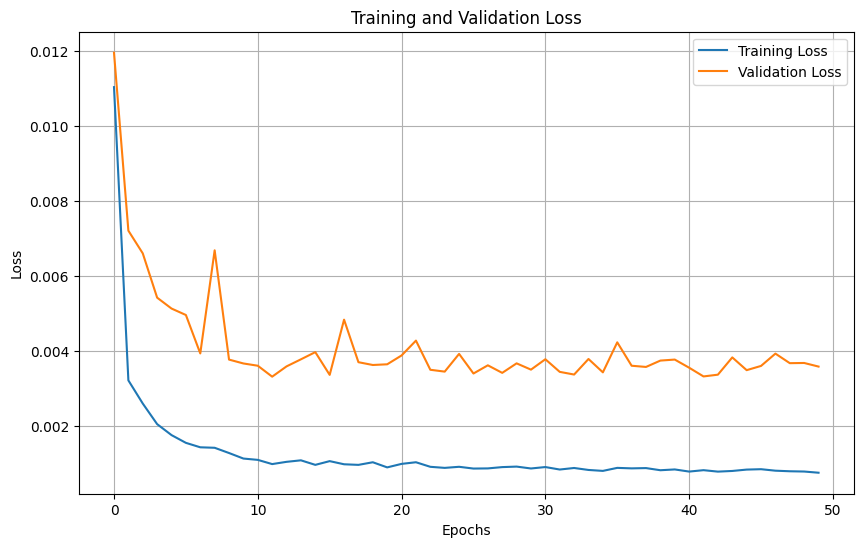

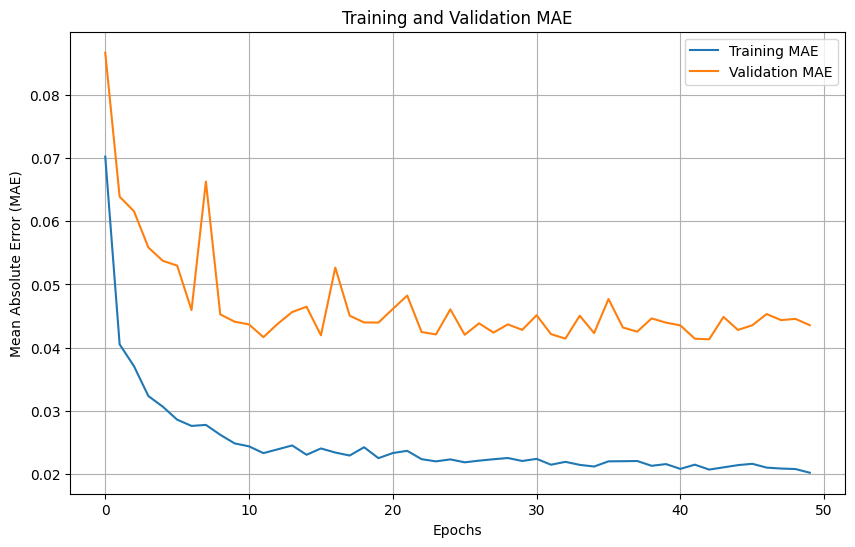

Training time: 1.2925267974535624 minutes
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0179 - mae: 0.0810   
Test Loss: 0.03451337292790413
Test MAE: 0.09460650384426117


In [181]:
train_stack_lstm_loop(X_train, y_train, 
                 X_val, y_val,
                 X_test, y_test,
                 "stacked_attention_lstm",
                )

In [182]:
model_stacked = tf.keras.models.load_model('/kaggle/input/stacked-attention-ltsm/keras/default/1/stacked_attention_lstm.keras')

# Evaluate them
print("Model Stacked")
evaluate_model_V2(model_stacked, X_test, y_test)


Model Stacked
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
R² - Stacked_Attention_LSTM_Model: 0.7685623995414868
MSE - Stacked_Attention_LSTM_Model: 0.034513372251820516
RMSE - Stacked_Attention_LSTM_Model: 0.18577774961448024
MAE - Stacked_Attention_LSTM_Model: 0.09460651473767828
MAPE - Stacked_Attention_LSTM_Model: 9.364376695820827


(0.7685623995414868,
 0.034513372251820516,
 0.18577774961448024,
 0.09460651473767828,
 9.364376695820827)